In [1]:
import os
from string import ascii_letters
from string import digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# データフレーム読み込み
folder_path = '/home/jovyan/work/train_data/DataFrame_csv'

file_path = os.path.join(folder_path, 'DataFrame.csv')
df = pd.read_csv(file_path, encoding='shift-jis')

In [3]:
df.columns

Index(['実着順', '選手登番', '展示', 'ｽﾀｰﾄﾀｲﾐﾝｸ', 'レースID', '艇番', '選手名', '年齢', '支部',
       '体重', '級別', '全国勝率', '全国2連率', '当地勝率', '当地2連率', 'モーターNO', 'モーター2連率',
       'ボート2連率', '開催地', '20前期_今期能力指数', '20後期_今期能力指数', '21前期_今期能力指数',
       '21後期_今期能力指数', '22前期_今期能力指数', '22後期_今期能力指数', '23前期_今期能力指数',
       '23後期_今期能力指数', '24前期_今期能力指数', '20前期コース別複勝率', '20前期コース別スタートタイミング',
       '20前期コース平均スタート順位', '20後期コース別複勝率', '20後期コース別スタートタイミング',
       '20後期コース平均スタート順位', '21前期コース別複勝率', '21前期コース別スタートタイミング',
       '21前期コース平均スタート順位', '21後期コース別複勝率', '21後期コース別スタートタイミング',
       '21後期コース平均スタート順位', '22前期コース別複勝率', '22前期コース別スタートタイミング',
       '22前期コース平均スタート順位', '22後期コース別複勝率', '22後期コース別スタートタイミング',
       '22後期コース平均スタート順位', '23前期コース別複勝率', '23前期コース別スタートタイミング',
       '23前期コース平均スタート順位', '23後期コース別複勝率', '23後期コース別スタートタイミング',
       '23後期コース平均スタート順位', '24前期コース別複勝率', '24前期コース別スタートタイミング',
       '24前期コース平均スタート順位'],
      dtype='object')

前回のtrainデータ作成時に、せっかく作った特徴量をここで削除します。競艇の予測は時系列データを扱い、レーサー期別データは特定期間の集計をしたもので、単にそのまま全データにマージしてしまうと、データリークが起きてしまい、モデルが過大評価されてしまいます。

In [4]:
# 学習に使用しないカラムを削除
df = df.drop(['展示','ｽﾀｰﾄﾀｲﾐﾝｸ','支部','選手名','選手登番','開催地',
                '20前期_今期能力指数', '20後期_今期能力指数', '21前期_今期能力指数', '21後期_今期能力指数', '22前期_今期能力指数', '22後期_今期能力指数', '23前期_今期能力指数', '23後期_今期能力指数', '24前期_今期能力指数',
                '20前期コース別複勝率', '20前期コース別スタートタイミング', '20前期コース平均スタート順位', '20後期コース別複勝率', '20後期コース別スタートタイミング', '20後期コース平均スタート順位',
                '21前期コース別複勝率', '21前期コース別スタートタイミング', '21前期コース平均スタート順位', '21後期コース別複勝率', '21後期コース別スタートタイミング', '21後期コース平均スタート順位',
                '22前期コース別複勝率', '22前期コース別スタートタイミング', '22前期コース平均スタート順位', '22後期コース別複勝率', '22後期コース別スタートタイミング', '22後期コース平均スタート順位',
                '23前期コース別複勝率', '23前期コース別スタートタイミング', '23前期コース平均スタート順位', '23後期コース別複勝率', '23後期コース別スタートタイミング', '23後期コース平均スタート順位',
                '24前期コース別複勝率', '24前期コース別スタートタイミング', '24前期コース平均スタート順位'

             ], axis=1)

In [5]:
# 二値分類前のdfをコピー
base_df = df.copy()

# '実着順'を二値分類のラベルに変換
df['実着順'] = df['実着順'].apply(lambda x: 1 if x == 1 else 0)

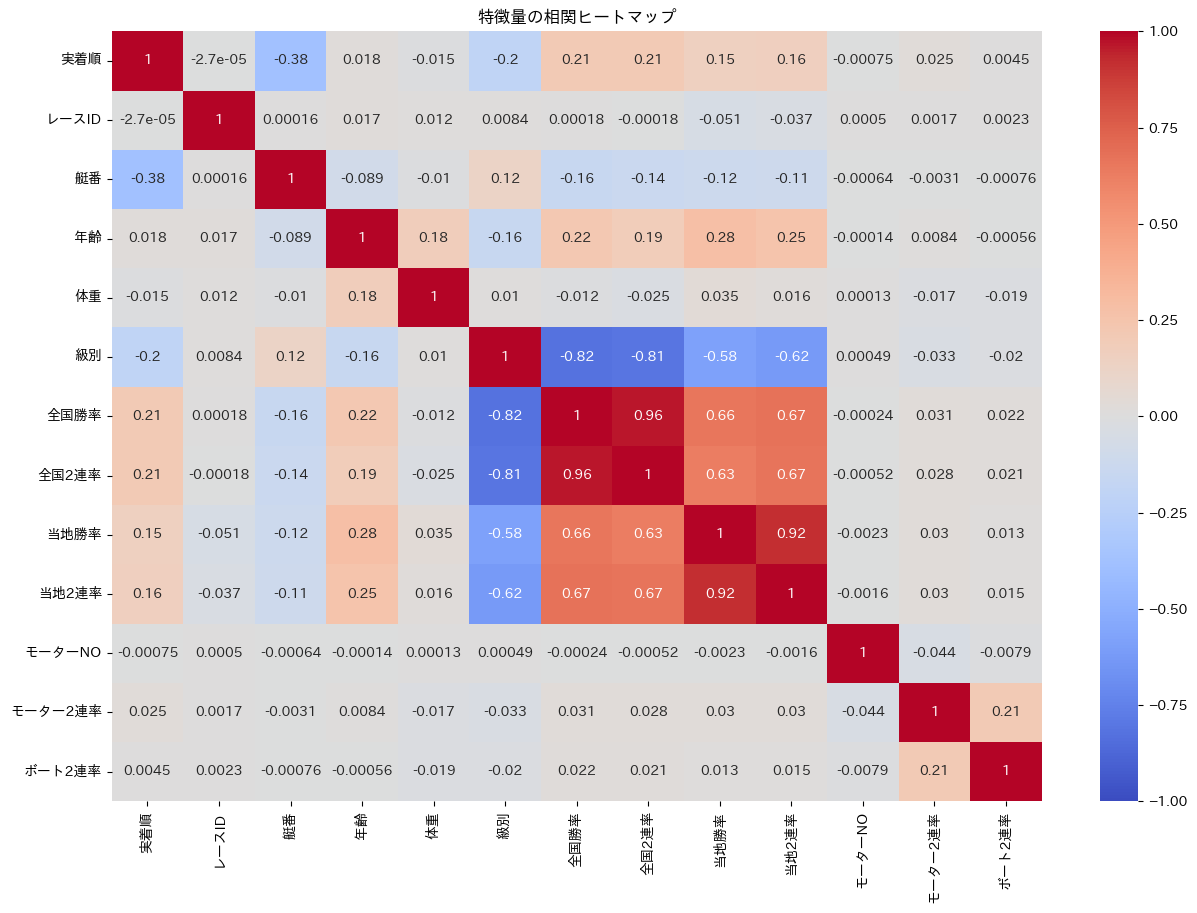

In [6]:
# 相関係数の計算
correlation_new = df.corr()

# ヒートマップの表示
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_new, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('特徴量の相関ヒートマップ')
plt.show()

In [7]:
columns_list = df.columns.tolist()
print(columns_list)

['実着順', 'レースID', '艇番', '年齢', '体重', '級別', '全国勝率', '全国2連率', '当地勝率', '当地2連率', 'モーターNO', 'モーター2連率', 'ボート2連率']


In [8]:
#訓練2ヶ月、検証半月、テスト半月パラメータ設定
date_split_test = 2405010000 # 訓練データとテストデータの分岐点（年+月+日+4桁（会場、レース番号））

# 訓練データ・テストデータに分割
df_train = df[df['レースID'] < date_split_test]
df_test = df[df['レースID'] >= date_split_test]

base_df_test = base_df[base_df['レースID'] >= date_split_test]

# 説明変数
X_train = df_train.drop(['実着順', 'レースID'], axis=1)
X_test = df_test.drop(['実着順', 'レースID'], axis=1)

# 目的変数
y_train = df_train['実着順'].astype("float32")
y_test = df_test['実着順'].astype("float32")

y_test_base = base_df_test['実着順'].astype("float32")

## LightGBMモデル作成

In [9]:
# 訓練データをさらに訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# データセットを作成
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

params = {
    'objective': 'binary',   # 目的 : 二値分類
    'metric': 'binary_error', # 評価指標 : 不正解率(1 - 正解率)
    'num_boost_round': 2000,
    'learning_rate': 0.01, 
    'num_leaves': 250,
    'feature_fraction': 0.9,
    'early_stopping_rounds': 100,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
}

# モデルの訓練
model = lgb.train(params, train_data, valid_sets=[valid_data])

# 検証データの予測
y_prob = model.predict(X_valid)
y_pred = (y_prob > 0.5).astype(int)

# 評価指標
acc = accuracy_score(y_valid, y_pred)
print('正解率 = ', acc)



[LightGBM] [Info] Number of positive: 176528, number of negative: 866848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1735
[LightGBM] [Info] Number of data points in the train set: 1043376, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169189 -> initscore=-1.591384
[LightGBM] [Info] Start training from score -1.591384
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[542]	valid_0's binary_error: 0.135016
正解率 =  0.8649844351413105


    feature  importance
9   モーター2連率       18124
4      全国勝率       16228
10   ボート2連率       15136
5     全国2連率       14731
1        年齢       14668
6      当地勝率       13879
7     当地2連率       13652
8    モーターNO       12946
2        体重        8468
0        艇番        4493
3        級別        2633


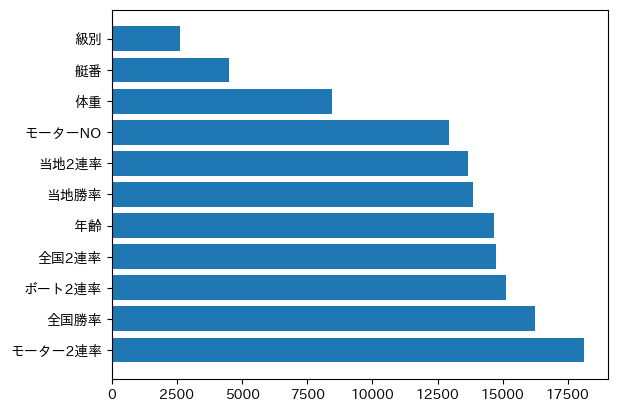

In [10]:
# 特徴量重要度
importance = np.array(model.feature_importance())  # bstはトレーニングしたLightGBMモデル
feature_names = X_train.columns  # 特徴量の列名を取得

df_f = pd.DataFrame({'feature': feature_names, 'importance': importance})
df_f = df_f.sort_values('importance', ascending=False)  # 重要度の降順でソート

# プロットする前に確認
print(df_f)

n = len(df_f) # 説明変数の項目数を取得
values = df_f['importance'].values
plt.barh(range(n), values)

values = df_f['feature'].values
plt.yticks(np.arange(n), values) # x, y軸の設定

plt.show()

In [11]:
# テストデータの予測
y_prob_test = model.predict(X_test)
y_pred_test = (y_prob_test > 0.5).astype(int)

# 評価指標
acc = accuracy_score(y_test, y_pred_test)
print('正解率 = ', acc)

正解率 =  0.8630174521541185


In [12]:
import pickle

# 学習モデルをmodel.pklに保存
with open('model.pkl', 'wb') as model_file:
	pickle.dump(model, model_file)

In [13]:
# 予測値を出力
df_result_p = pd.DataFrame({'1着予測値':y_prob_test,'予測フラグ': y_pred_test, '実着順': y_test_base})
df_result_p['レースID'] = df_test['レースID'].values  # 'レースID'列を追加
df_result_p['実着順'] = base_df_test['実着順'].values  # '実着順'列を追加
df_result_p['艇番'] = base_df_test['艇番'].values  # '実着順'列を追加

# 'レースID'カラムでグループ化し、'1着予測確率'のデータを大きい順にソートする
df_result_p['予測順位'] = df_result_p.groupby('レースID')['1着予測値'].rank(method='first', ascending=False).astype(int)

# レース場コード抜き出し
df_result_p['レース場コード'] = df_result_p['レースID'].astype(str).str[6:8]

df_result_p

,1着予測値,予測フラグ,実着順,レースID,艇番,予測順位,レース場コード
1304220,0.765051,1,1,2405012101,1,1,21
1304221,0.095772,0,2,2405012101,2,3,21
1304222,0.131394,0,3,2405012101,3,2,21
1304223,0.044551,0,4,2405012101,5,5,21
1304224,0.079904,0,5,2405012101,4,4,21
...,...,...,...,...,...,...,...
1493991,0.230730,0,2,2411300312,2,2,03
1493992,0.072871,0,3,2411300312,5,5,03
1493993,0.065805,0,4,2411300312,6,6,03
1493994,0.129413,0,5,2411300312,3,3,03


In [14]:
#払戻金確認
folder_path = '/home/jovyan/work/train_data/results_csv_detail'

file_path = os.path.join(folder_path, 'results_detail.csv')
df_result_detail = pd.read_csv(file_path, encoding='shift-jis', dtype={'レースID': str})


/tmp/ipykernel_2638/2456593600.py:5: DtypeWarning: Columns (15,17,23,29,30,39,40,41,50,51,60,61,76,77,78,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df_result_detail = pd.read_csv(file_path, encoding='shift-jis', dtype={'レースID': str})


In [15]:
#'レースID'と'単勝_払戻金'のカラムを取り出す
selected_columns = ['レースID', '単勝_払戻金','2連単_払戻金','2連複_払戻金','3連単_払戻金','3連複_払戻金']
df_selected = df_result_detail[selected_columns]

In [16]:
df_result_p['レースID'] = df_result_p['レースID'].astype(str)
df_result_p = pd.merge(df_result_p, df_selected, on='レースID', how='left')

In [17]:
df_result_p

,1着予測値,予測フラグ,実着順,レースID,艇番,予測順位,レース場コード,単勝_払戻金,2連単_払戻金,2連複_払戻金,3連単_払戻金,3連複_払戻金
0,0.765051,1,1,2405012101,1,1,21,100.0,330.0,250,630.0,290.0
1,0.095772,0,2,2405012101,2,3,21,100.0,330.0,250,630.0,290.0
2,0.131394,0,3,2405012101,3,2,21,100.0,330.0,250,630.0,290.0
3,0.044551,0,4,2405012101,5,5,21,100.0,330.0,250,630.0,290.0
4,0.079904,0,5,2405012101,4,4,21,100.0,330.0,250,630.0,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...
189771,0.230730,0,2,2411300312,2,2,03,100.0,270.0,150,1460.0,770.0
189772,0.072871,0,3,2411300312,5,5,03,100.0,270.0,150,1460.0,770.0
189773,0.065805,0,4,2411300312,6,6,03,100.0,270.0,150,1460.0,770.0
189774,0.129413,0,5,2411300312,3,3,03,100.0,270.0,150,1460.0,770.0


In [18]:
#保存するフォルダのパスを指定します
folder_path = '予測結果'

# ファイルのパスをフォルダパスと結合してCSVファイルを保存します
file_path = os.path.join(folder_path, '予測結果.csv')
df_result_p.to_csv(file_path, index=False, encoding='shift-jis')

## モデルの的中率、回収率

In [19]:
# '予測値'が1であるときに'実測値'も1であった確率を計算
df_filtered = df_result_p[df_result_p['予測フラグ'] == 1]
probability = (df_filtered['実着順'] == 1).mean()

print("全体の的中率:", probability)

# '予測値'が1で'実着順'も1である場合の'単勝_払戻金'の合計値を計算
total_payout_win = df_result_p[(df_result_p['予測フラグ'] == 1) & (df_result_p['実着順'] == 1)]['単勝_払戻金'].sum()

# '予測値'が1の場合の'予測値'の合計値に100を掛けた値を計算
total_predict_value = df_result_p[df_result_p['予測フラグ'] == 1]['予測フラグ'].sum() * 100

# 計算した値を割り算して結果を求める
result = total_payout_win / total_predict_value if total_predict_value != 0 else 0

print("全体の回収率:", result)

全体の的中率: 0.6527987136971158
全体の回収率: 0.9143905135162296


In [20]:
# レース場コードと名称の辞書
race_track_dict = {
    1: '桐生', 2: '戸田', 3: '江戸川', 4: '平和島', 5: '多摩川', 6: '浜名湖',
    7: '蒲郡', 8: '常滑', 9: '津', 10: '三国', 11: 'びわこ', 12: '住之江',
    13: '尼崎', 14: '鳴門', 15: '丸亀', 16: '児島', 17: '宮島', 18: '徳山',
    19: '下関', 20: '若松', 21: '芦屋', 22: '福岡', 23: '唐津', 24: '大村'
}

df_result_p['レース場コード'] = df_result_p['レース場コード'].astype("int64")

# レース場コードが1から24の値ごとに計算を行う
for race_code in range(1, 25):
    # 対象のレース場コードのデータをフィルタリング
    df_filtered = df_result_p[(df_result_p['レース場コード'] == race_code) & (df_result_p['予測フラグ'] == 1)]

    # 的中率の計算
    probability = (df_filtered['実着順'] == 1).mean()
    
    # 回収率の計算
    total_payout_win = df_filtered[df_filtered['実着順'] == 1]['単勝_払戻金'].sum()
    total_predict_value = df_filtered['予測フラグ'].sum() * 100
    result = total_payout_win / total_predict_value if total_predict_value != 0 else 0

    # 予測値が1であるエントリの数をカウント
    count_predict_1 = df_filtered.shape[0]

    # レース場名称を取得
    race_track_name = race_track_dict.get(race_code, "不明")

    print(f"レース場コード {race_code} ({race_track_name}): 的中率 = {probability:.2f}, 回収率 = {result:.2f}")


レース場コード 1 (桐生): 的中率 = 0.62, 回収率 = 0.90
レース場コード 2 (戸田): 的中率 = 0.55, 回収率 = 0.87
レース場コード 3 (江戸川): 的中率 = 0.61, 回収率 = 1.03
レース場コード 4 (平和島): 的中率 = 0.52, 回収率 = 0.85
レース場コード 5 (多摩川): 的中率 = 0.66, 回収率 = 0.94
レース場コード 6 (浜名湖): 的中率 = 0.63, 回収率 = 0.95
レース場コード 7 (蒲郡): 的中率 = 0.70, 回収率 = 0.97
レース場コード 8 (常滑): 的中率 = 0.70, 回収率 = 0.95
レース場コード 9 (津): 的中率 = 0.65, 回収率 = 0.87
レース場コード 10 (三国): 的中率 = 0.62, 回収率 = 0.89
レース場コード 11 (びわこ): 的中率 = 0.63, 回収率 = 0.91
レース場コード 12 (住之江): 的中率 = 0.69, 回収率 = 0.93
レース場コード 13 (尼崎): 的中率 = 0.69, 回収率 = 0.92
レース場コード 14 (鳴門): 的中率 = 0.62, 回収率 = 0.84
レース場コード 15 (丸亀): 的中率 = 0.68, 回収率 = 0.93
レース場コード 16 (児島): 的中率 = 0.67, 回収率 = 0.93
レース場コード 17 (宮島): 的中率 = 0.65, 回収率 = 0.91
レース場コード 18 (徳山): 的中率 = 0.72, 回収率 = 0.92
レース場コード 19 (下関): 的中率 = 0.64, 回収率 = 0.89
レース場コード 20 (若松): 的中率 = 0.67, 回収率 = 0.94
レース場コード 21 (芦屋): 的中率 = 0.67, 回収率 = 0.87
レース場コード 22 (福岡): 的中率 = 0.65, 回収率 = 0.91
レース場コード 23 (唐津): 的中率 = 0.64, 回収率 = 0.88
レース場コード 24 (大村): 的中率 = 0.73, 回収率 = 0.98
